In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import jax
import jax.numpy as jnp
from evosax import CMA_ES, SimAnneal

from envs.photon_env import BatchedPhotonLangevinReadoutEnv

In [72]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [73]:
env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [74]:
# Instantiate the search strategy
rng = jax.random.PRNGKey(0)
strategy = CMA_ES(popsize=batchsize, num_dims=env.num_actions, elite_ratio=0.6)
es_params = strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)
es_params

EvoParams(mu_eff=Array(16.98963432, dtype=float64), c_1=Array(0.00013356, dtype=float64), c_mu=Array(0.00198713, dtype=float64), c_sigma=Array(0.13280427, dtype=float64), d_sigma=Array(1.13280427, dtype=float64), c_c=Array(0.03304903, dtype=float64), chi_n=Array(10.9773085, dtype=float64, weak_type=True), c_m=1.0, sigma_init=1.0, init_min=-1, init_max=1, clip_min=-2.3255813953488373, clip_max=2.3255813953488373)

In [75]:
# Simulated Annealing

sim_anneal = SimAnneal(popsize=batchsize, num_dims=env.num_actions)
sim_params = sim_anneal.default_params
sim_params = sim_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu,)

In [76]:
def custom_rollout(batch_actions):
    res_drive = env.a0 * batch_actions.astype(jnp.float64)
    normalizing_factor = jnp.clip(
        env.mu * env.a0 / jnp.absolute(res_drive),
        0.0,
        1.0,
    )
    res_drive *= normalizing_factor
    res_drive = env.batched_smoother(res_drive)

    batch_res = env.batched_results(res_drive)
    reward, _ = env.batched_reward_and_state(
        batch_res.astype(env.float_dtype), res_drive
    )

    fitness = -reward # Since we are dealing with minimisation

    return fitness.astype(jnp.float32)

In [84]:
import time

strat = sim_anneal
params = sim_params

state = strat.initialize(rng, params)

start = time.time()
fitness_list = []

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(int(2e4)):
    rng, rng_gen, rng_eval = jax.random.split(rng, 3)
    x, state = strat.ask(rng_gen, state, params)
    fitness = custom_rollout(x)
    state = strat.tell(x, fitness, state, params)
    fitness_list.append(state.best_fitness)

    if (t + 1) % 100 == 0:
        # print("CMA-ES - # Gen: {}|Fitness: {:.5f}|Params: {}".format(
        #     t+1, state.best_fitness, state.best_member))
        print("CMA-ES - # Gen: {}|Fitness: {:.5f}".format(
            t+1, state.best_fitness))
        print(f"Time: {time.time() - start}")

CMA-ES - # Gen: 100|Fitness: 5.92934
Time: 1.8915886878967285
CMA-ES - # Gen: 200|Fitness: 1.93154
Time: 3.50805401802063
CMA-ES - # Gen: 300|Fitness: -0.11053
Time: 5.026551723480225
CMA-ES - # Gen: 400|Fitness: -2.28321
Time: 6.45598578453064
CMA-ES - # Gen: 500|Fitness: -3.96333
Time: 7.92417573928833
CMA-ES - # Gen: 600|Fitness: -3.96333
Time: 9.483978986740112
CMA-ES - # Gen: 700|Fitness: -3.96333
Time: 10.904189825057983
CMA-ES - # Gen: 800|Fitness: -4.32046
Time: 12.34237790107727
CMA-ES - # Gen: 900|Fitness: -4.47318
Time: 13.83265995979309
CMA-ES - # Gen: 1000|Fitness: -4.82623
Time: 15.253383874893188
CMA-ES - # Gen: 1100|Fitness: -4.82623
Time: 16.736940622329712
CMA-ES - # Gen: 1200|Fitness: -4.82623
Time: 18.15484070777893
CMA-ES - # Gen: 1300|Fitness: -6.05489
Time: 19.584885597229004
CMA-ES - # Gen: 1400|Fitness: -6.11029
Time: 21.065143585205078
CMA-ES - # Gen: 1500|Fitness: -7.53803
Time: 22.501917839050293
CMA-ES - # Gen: 1600|Fitness: -7.60243
Time: 23.98127055168152

KeyboardInterrupt: 

[-0.17576878 -0.01676424  1.335455    0.38234205  1.69316659  0.81364898
  1.48878258  1.33564173  1.43307287  1.14978989  1.50758705  0.9795602
  1.41965595  1.46254126  1.47910801  1.87805938  1.43276257  1.44910408
  1.80727834  1.58736095  1.35073456  1.45035931  0.88507288  1.87563831
  1.18645431  1.30831503  1.89331121  1.24815902  1.75148042  1.88533048
  1.39142629  2.20588012  1.60192826  1.83297864  2.08699685  1.58269621
  1.9305822   1.97128977  1.30170347  2.20390207  0.92071995  2.08733399
  1.18899388  1.5661313   1.16009391  1.3227955   1.20506179  1.14645472
  1.18290649  0.89069099  1.29547864  0.20544006  0.70243005 -0.02315173
  0.40858175 -0.5634344  -0.56692347 -0.75122784 -0.87950557 -1.29171791
 -1.05005285 -2.02490869 -0.56453205 -2.21544385 -0.51617604 -1.90123061
 -0.75342592 -1.28334191 -1.24203397 -1.39716168 -1.39210562 -1.78268006
 -0.96688732 -2.05327285 -0.81794397 -2.00966919 -0.78757222 -1.5924717
 -0.89643782 -1.42581623 -1.12995531 -1.15790727 -2.0

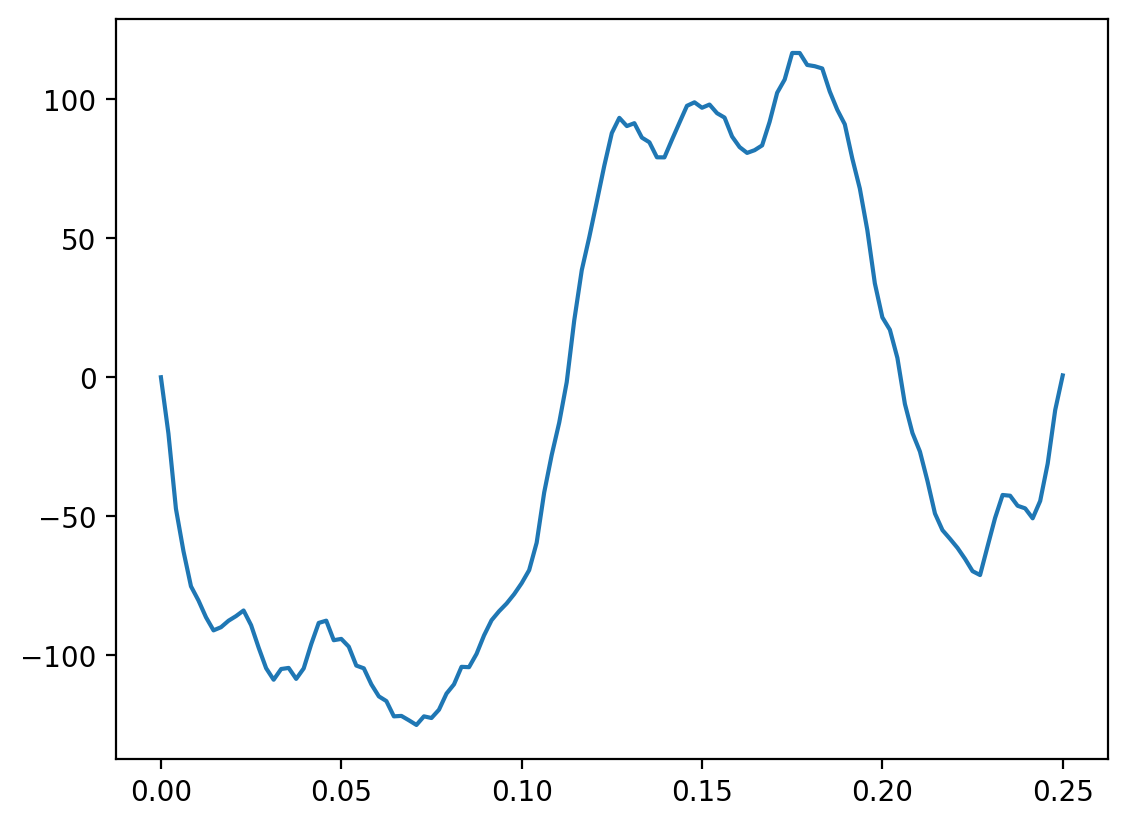

In [85]:
import matplotlib.pyplot as plt

action = state.best_member
action *= env.a0
action = -env.drive_smoother(action)

print(state.best_member)
plt.plot(env.ts_action, action)
plt.show()

In [86]:
batched_action = jnp.tile(action, (batchsize, 1))

batched_res = env.batched_results(batched_action)
(
    max_pf,
    max_photons,
    photon_reset_time,
    pulse_end_times,
    max_pf_times,
    smoothness_vals,
    b_pf,
    b_higher_photons,
    _
) = env.batched_extract_values(batched_res, batched_action)

reward, _ = env.batched_reward_and_state(
    batched_res,
    batched_action
)

print(max_pf_times[0])
print(photon_reset_time[0])
print(pulse_end_times[0])
print(reward[0])
print(max_pf[0])

0.12152777777777778
0.25749228683753345
0.25
22.83383845424791
2.5554518677711213


0.00991310817563478
356
0.00991310817563478
356


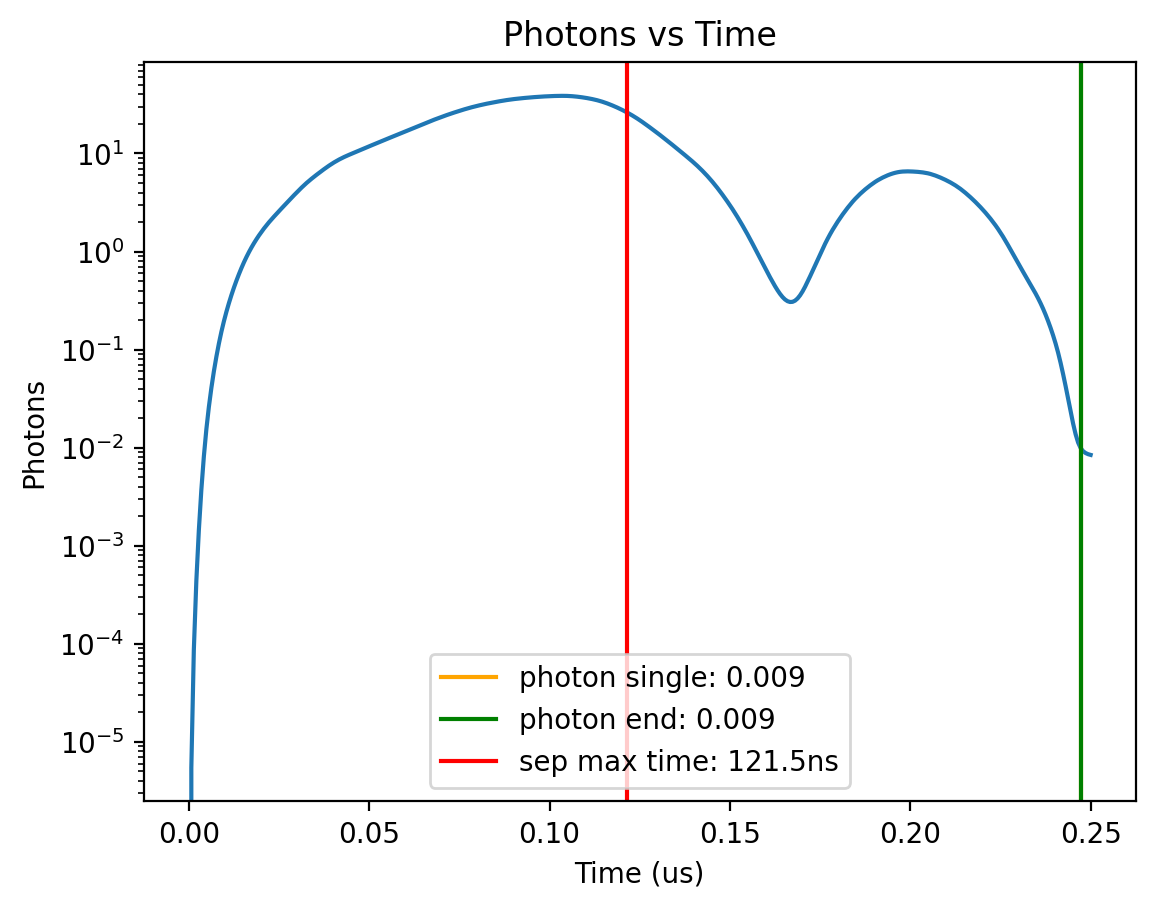

In [87]:
single_photon = b_higher_photons[0]

single_res = batched_res[0]
g_real, g_imag, e_real, e_imag = single_res.T
single_sep = jnp.sqrt((g_real - g_imag) ** 2 + (e_real - e_imag) ** 2)
single_sep = b_pf[0]

single_photon = g_real ** 2 + g_imag ** 2

ext = 50
ext_15 = -1
ext_2 = -1

s_photon = jnp.abs(single_photon - nR)

argmin = jnp.argmin(s_photon[ext:ext_2]) + ext
min_photon = single_photon[argmin]

argmin_2 = jnp.argmin(s_photon[ext:ext_15]) + ext
min_photon_2 = single_photon[argmin_2]

argmax = jnp.argmax(single_sep)

print(min_photon)
print(argmin)

print(min_photon_2)
print(argmin_2)

plt.plot(env.ts_sim, single_photon)
plt.axvline(x=env.ts_sim[argmin_2], label=f'photon single: {int(1e3*min_photon_2)/1e3}', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'photon end: {int(1e3*min_photon)/1e3}', color='green')
plt.axvline(x=env.ts_sim[argmax], label=f'sep max time: {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.xlabel('Time (us)')
plt.ylabel('Photons')
plt.title('Photons vs Time')
plt.yscale('log')
plt.legend()
plt.show()

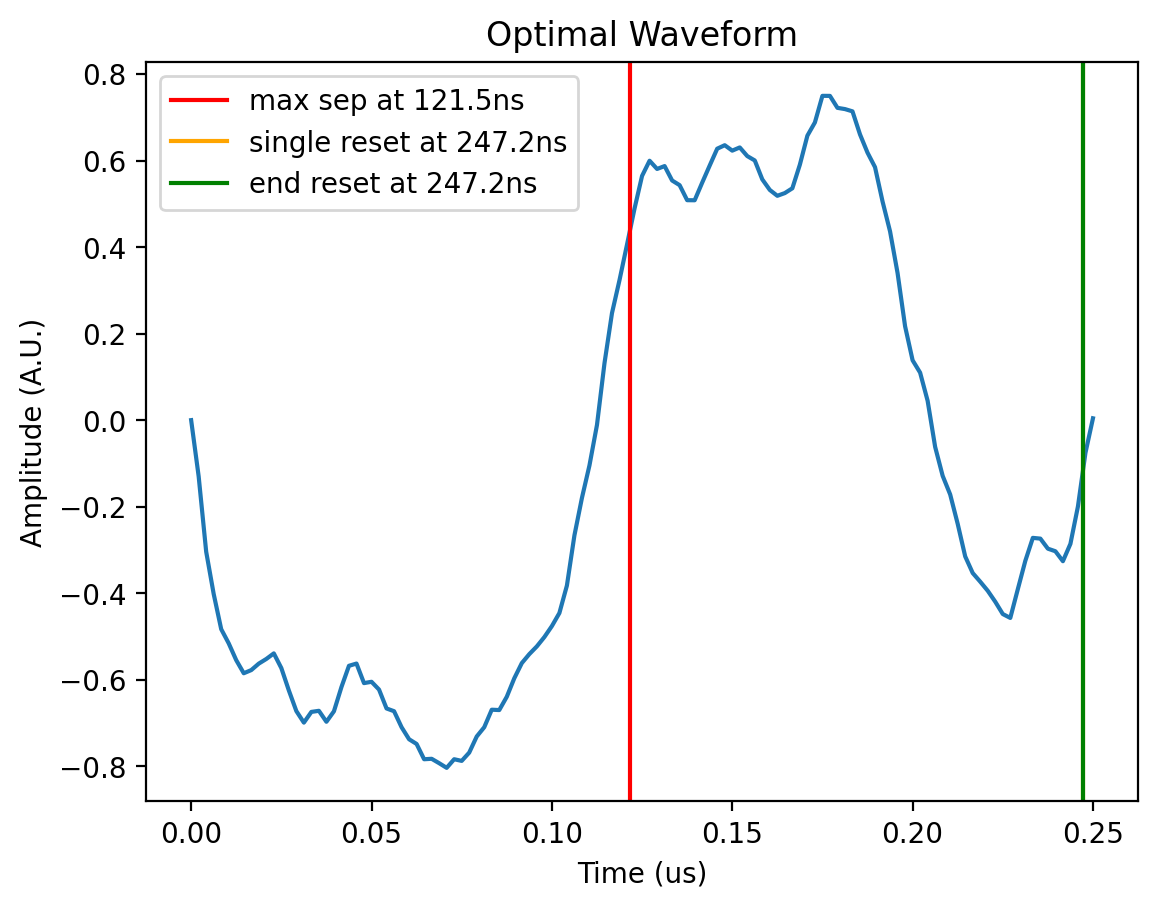

In [89]:
plt.plot(env.ts_action, action / env.mu / env.a0)
plt.axvline(x=env.ts_sim[argmax], label=f'max sep at {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.axvline(x=env.ts_sim[argmin_2], label=f'single reset at {int(1e4*env.ts_sim[argmin_2])/1e1}ns', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'end reset at {int(1e4*env.ts_sim[argmin])/1e1}ns', color='green')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.title('Optimal Waveform')
plt.legend()
plt.show()

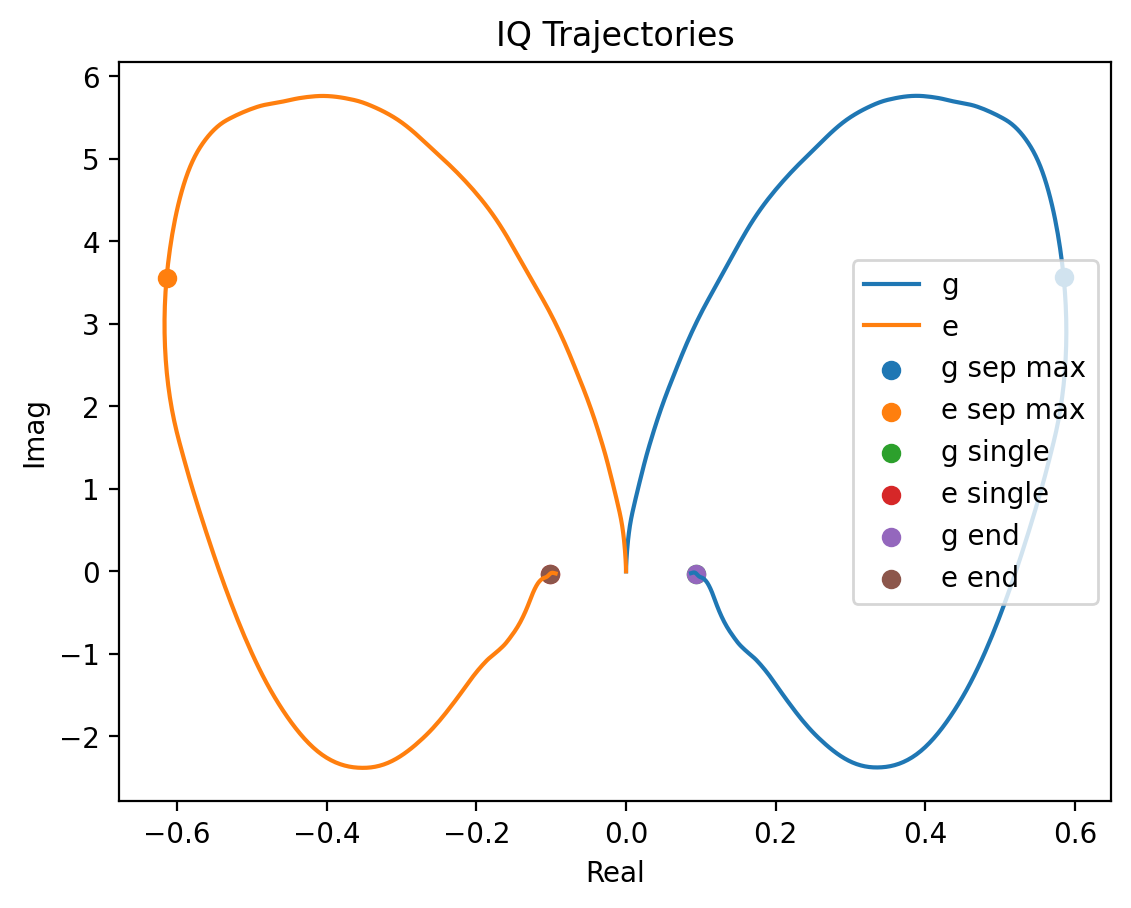

In [82]:
plt.plot(g_real, g_imag, label='g')
plt.plot(e_real, e_imag, label='e')
plt.scatter(g_real[argmax], g_imag[argmax], label='g sep max')
plt.scatter(e_real[argmax], e_imag[argmax], label='e sep max')
plt.scatter(g_real[argmin_2], g_imag[argmin_2], label='g single')
plt.scatter(e_real[argmin_2], e_imag[argmin_2], label='e single')
plt.scatter(g_real[argmin], g_imag[argmin], label='g end')
plt.scatter(e_real[argmin], e_imag[argmin], label='e end')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('IQ Trajectories')
plt.legend()
plt.show()

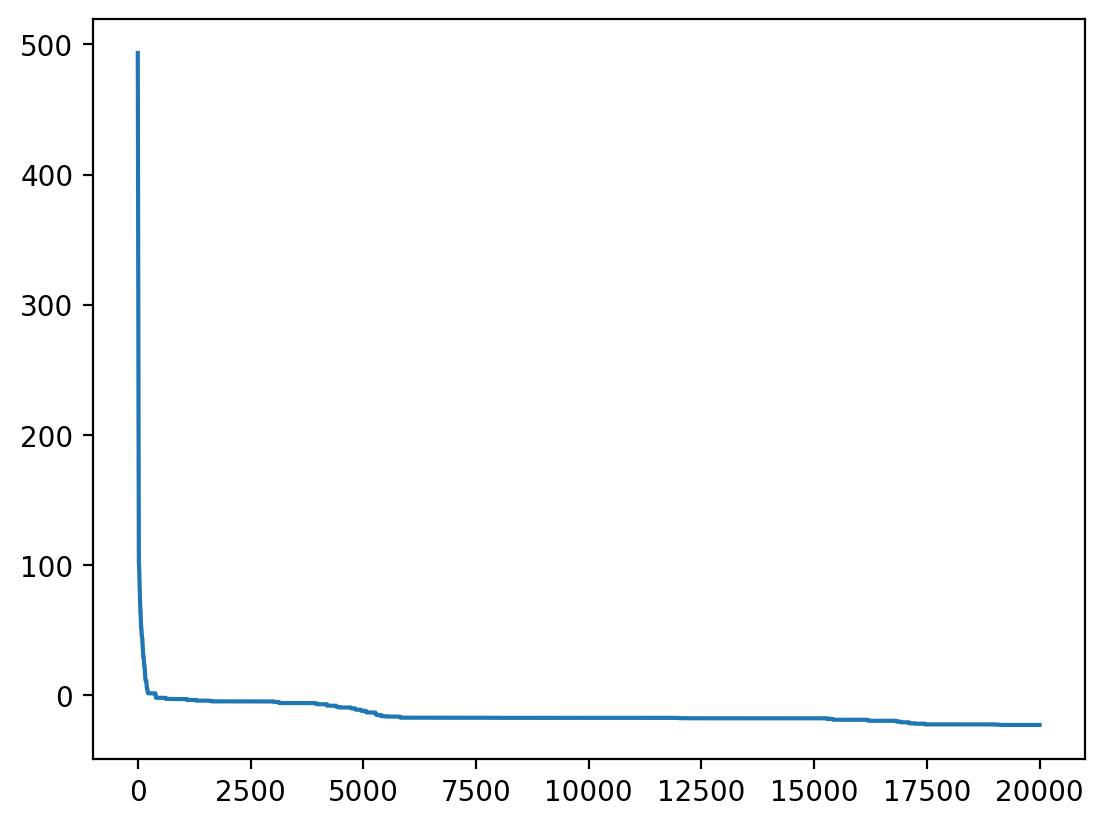

In [83]:
plt.plot(fitness_list)